# Predictive Maintenance

## Step 2: Train Neural Network

### Prerequisites

For this notebook you need to install:

- `pandas`
- `numpy`
- `keras`
- `matplotlib.pyplot`

### What does this file do ?

This file builds and fit the Neural Network algorithm to the train data set. It is imperative that a `train.csv` file has been built with the `preprocess.py` script.

### When do I need to run it ?

This file extracts preprocessed train data from the `..\input\` folder and fit the Neural Network with it.

Thus, this script is needed if the train set is modified. Be careful, it requires computer ressources and time to process.

In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# where to save the model output file
output_path = 'model/regression_model_v0.h5'

In [3]:
train_data = pd.read_csv('input/train.csv')
n_turb = train_data['id'].unique().max()

## 1. Shape the train set

In order to correctly train the Neural Network, we need to reshape the data.

The point is to obtain a train set that has shape (n_turbines, n_cycles, n_features).

In [4]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def reshapeFeatures(id_df, seq_length, seq_cols):
    """
    Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length.
    An alternative would be to pad sequences so that
    we can use shorter ones.
    
    :param id_df: the data set to modify
    :param seq_length: the length of the window
    :param seq_cols: the columns concerned by the step
    :return: a generator of the sequences
    """
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [5]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
feat_gen = (list(reshapeFeatures(train_data[train_data['id']==id], sequence_length, sequence_cols)) 
           for id in range(1, n_turb + 1))

# generate sequences and convert to numpy array
feat_array = np.concatenate(list(feat_gen)).astype(np.float32)

print("The data set has now shape: {} entries, {} cycles and {} features.".format(feat_array.shape[0],
                                                                                  feat_array.shape[1],
                                                                                  feat_array.shape[2]))

The data set has now shape: 15631 entries, 50 cycles and 25 features.


In [6]:
# function to generate label
def reshapeLabel(id_df, seq_length=sequence_length, label=['RUL']):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length."""
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length: num_elements, :]

# generate labels
label_gen = [reshapeLabel(train_data[train_data['id']==id]) for id in range(1, n_turb + 1)]

label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(15631, 1)


## 2. Modeling

Now that the train data set is corrected, we can build and fit the Recurrent Neural Network.

### 2.1 Create a Recurrent Neural Network

In order to take into account the dependancy of a given Time Serie (i.e. for a turbine), we use LSTM (Long Short Term Memory) Recurrent Neural Network.

The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units and a LSTM layer with 25 units. 

Dropout is also applied after each LSTM layer to control overfitting. 

Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.

The model is refined using `mean_squared_error` loss function.

The metrics used are `root_mean_squared_error` as well as `mae` (i.e. Mean Absolute Error). The `root_mean_squared_error` is easier to understand the `mean_squared_error`, as it is closer to the real value of the data.

In [7]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

nb_features = feat_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True, name="lstm_0"))
model.add(Dropout(0.2, name="dropout_0"))
model.add(LSTM(units=50, return_sequences=True, name="lstm_1"))
model.add(Dropout(0.2, name="dropout_1"))
model.add(LSTM(units=25, return_sequences=False, name="lstm_2"))
model.add(Dropout(0.2, name="dropout_2"))
model.add(Dense(units=nb_out, name="dense_0"))
model.add(Activation("linear", name="activation_0"))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[root_mean_squared_error, 'mae'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_0 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_0 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 1)                 26        
__________

### 2.1 Train the Recurrent Neural Network

In this step, we fit the Neural Network to the train set.

The `epochs` and `batch_size` are hyper-parameters of the Neural Network.

The `callbacks` parameter in the `fit` function allows to speed up the process and register the model.

In [8]:
epochs = 100
batch_size = 200

# fit the network
history = model.fit(feat_array, label_array, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,
                                                     verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(output_path, monitor='val_loss',
                                                       save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())
print("Model saved as {}".format(output_path))

Train on 14849 samples, validate on 782 samples
Epoch 1/100
14849/14849 [==============================] - 31s 2ms/step - loss: 9461.6192 - root_mean_squared_error: 78.9390 - mean_absolute_error: 78.9390 - val_loss: 9035.9184 - val_root_mean_squared_error: 77.0038 - val_mean_absolute_error: 77.0038
Epoch 2/100
14849/14849 [==============================] - 29s 2ms/step - loss: 9063.9990 - root_mean_squared_error: 76.6122 - mean_absolute_error: 76.6122 - val_loss: 8741.7642 - val_root_mean_squared_error: 75.2800 - val_mean_absolute_error: 75.2800
Epoch 3/100
14849/14849 [==============================] - 31s 2ms/step - loss: 8772.1853 - root_mean_squared_error: 74.9137 - mean_absolute_error: 74.9137 - val_loss: 8454.6714 - val_root_mean_squared_error: 73.6016 - val_mean_absolute_error: 73.6016
Epoch 4/100
14849/14849 [==============================] - 28s 2ms/step - loss: 8489.6059 - root_mean_squared_error: 73.2751 - mean_absolute_error: 73.2751 - val_loss: 8176.4751 - val_root_mean_sq

14849/14849 [==============================] - 26s 2ms/step - loss: 3585.9088 - root_mean_squared_error: 46.7340 - mean_absolute_error: 46.7340 - val_loss: 3398.7907 - val_root_mean_squared_error: 45.9212 - val_mean_absolute_error: 45.9213
Epoch 34/100
14849/14849 [==============================] - 27s 2ms/step - loss: 3524.7498 - root_mean_squared_error: 46.5390 - mean_absolute_error: 46.5390 - val_loss: 3345.9764 - val_root_mean_squared_error: 45.7335 - val_mean_absolute_error: 45.7335
Epoch 35/100
14849/14849 [==============================] - 27s 2ms/step - loss: 3486.0158 - root_mean_squared_error: 46.4403 - mean_absolute_error: 46.4403 - val_loss: 3301.6932 - val_root_mean_squared_error: 45.5942 - val_mean_absolute_error: 45.5942
Epoch 36/100
14849/14849 [==============================] - 27s 2ms/step - loss: 3446.9140 - root_mean_squared_error: 46.3461 - mean_absolute_error: 46.3461 - val_loss: 3265.7215 - val_root_mean_squared_error: 45.4987 - val_mean_absolute_error: 45.4987
E

14849/14849 [==============================] - 31s 2ms/step - loss: 935.9747 - root_mean_squared_error: 18.2362 - mean_absolute_error: 18.2362 - val_loss: 865.6058 - val_root_mean_squared_error: 16.9514 - val_mean_absolute_error: 16.9514
Epoch 66/100
14849/14849 [==============================] - 30s 2ms/step - loss: 920.9103 - root_mean_squared_error: 18.1881 - mean_absolute_error: 18.1881 - val_loss: 815.1519 - val_root_mean_squared_error: 16.4642 - val_mean_absolute_error: 16.4642
Epoch 67/100
14849/14849 [==============================] - 30s 2ms/step - loss: 888.4402 - root_mean_squared_error: 17.8280 - mean_absolute_error: 17.8280 - val_loss: 755.7341 - val_root_mean_squared_error: 16.7458 - val_mean_absolute_error: 16.7458
Epoch 68/100
14849/14849 [==============================] - 32s 2ms/step - loss: 863.2143 - root_mean_squared_error: 17.6177 - mean_absolute_error: 17.6177 - val_loss: 884.0434 - val_root_mean_squared_error: 18.6124 - val_mean_absolute_error: 18.6124
Epoch 69/

## Plot the results

We then plot the results of the simulation.

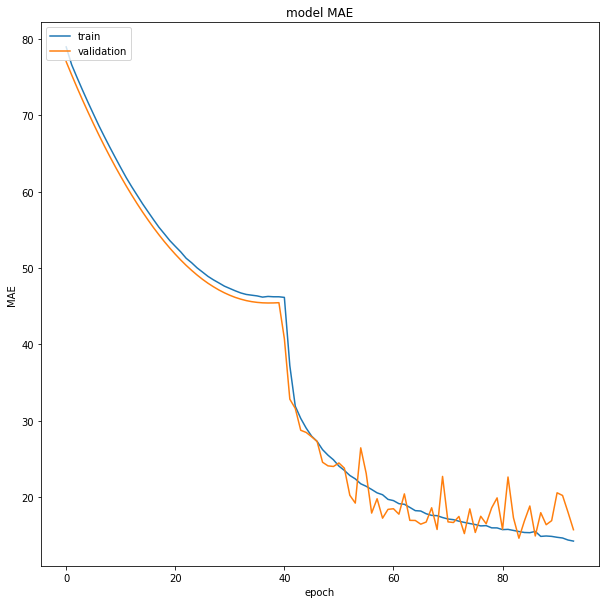

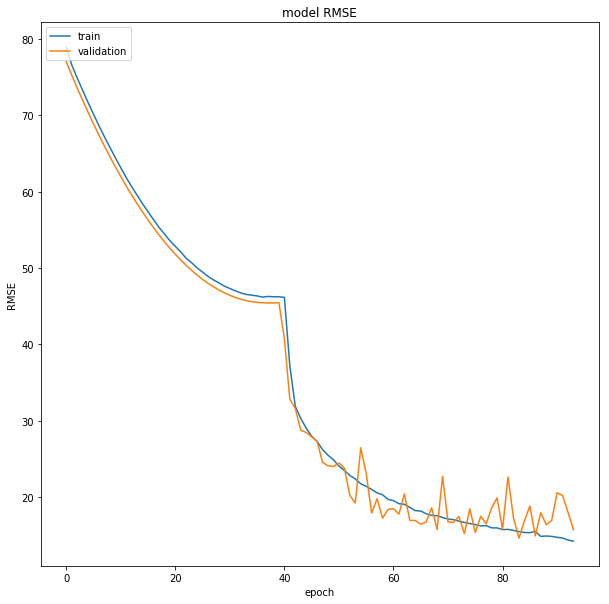

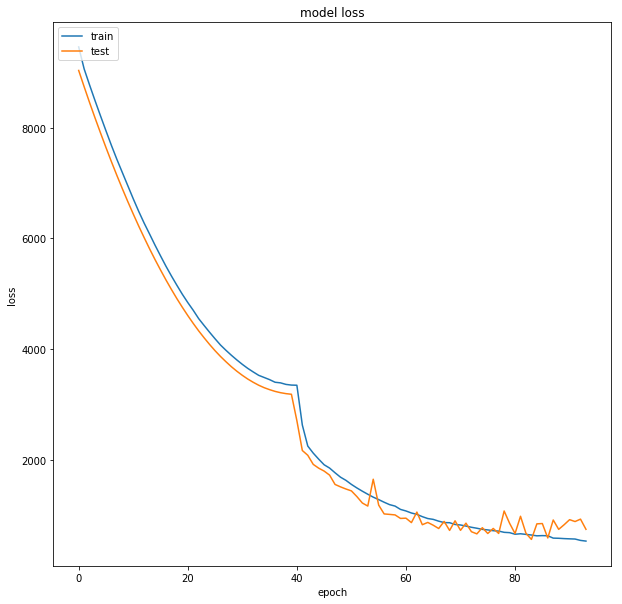

In [9]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("output/model_mae.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("output/model_rmse.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("output/model_regression_loss.png")